# Thymio visits its first museum 

Today, thymio wants to go to the museum. Since he's never been in a art museum, he decide to go to the famous "Aseba Museum"! 
The lady at the entrance gives him a map of the museum and thymio decides to study it before visiting.
He goes in the cafeteria, order a cup of coffee and take his 4-colors pen.
He circles in red all the painting he wants to see, and draw a green path to see them all.

The adventure now begins:


**Library to import**

In [53]:
import cv2
import time

import numpy as np
from math import *

%matplotlib notebook 
import matplotlib.pyplot as plt
%matplotlib notebook
from matplotlib import colors
%matplotlib inline

from bokeh.plotting import figure
from bokeh.io import output_notebook, show, push_notebook
from tqdm import tqdm

import IPython.display as Disp
from ipywidgets import widgets

**Magic numbers**

In [54]:
#Code for the occupancy grid 
obstacle_here = 1
painting_here = 2

**Define global variables**

In [55]:
#Size of the grid (defined in get_params())
global max_val_x, max_val_y

**VISION PROCESSING**

In [56]:
def detect_image(img, template, display_images):
    """
    Find template in img and draw a rectangle on it
        if display_images, display the image
    :return: coordinates of the center of the template in the image
    """
    w, h = template.shape[::-1]
    
    method = cv2.TM_SQDIFF_NORMED

    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
    
    #take minimum (due to the choice of the method)
    top_left = min_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    #draw rectangle in img 
    cv2.rectangle(img,top_left, bottom_right, (0,0,255), 7)

    if display_images:
        plt.figure()
        ax4 = plt.subplot(121),plt.imshow(res, cmap = 'gray')
        plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
        ax5 = plt.subplot(122),plt.imshow(img, cmap = 'gray')
        plt.title('Detected picture'), plt.xticks([]), plt.yticks([])
        plt.suptitle(method)
        
        plt.show()
        
    center = [(top_left[0] + bottom_right[0])/2, (top_left[1] + bottom_right[1])/2]
    return center #coordinates of the center of the image.

-Why did we use this filter?

-Bw_photo is not used --> bilateralFilter not used ? *Change to used, if no need to detect marker --> ok*


In [57]:
def filtering(name_img, display_images):
    """
    Filter the image using bilateral filter and otsu thersholding 
        if display_images, display the image
    :return: image filtered
    """
    photo = cv2.imread(name_img)
    bilateral = cv2.bilateralFilter(photo,9,75,75)
    
    #convert image in BW
    bw_photo = cv2.cvtColor(bilateral, cv2.COLOR_BGR2GRAY)

    #ret2,th2 = cv2.threshold(cv2.cvtColor(photo, cv2.COLOR_BGR2GRAY),0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    _,filtered_image = cv2.threshold(bw_photo,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    if display_images:
        plt.figure()
        ax = plt.subplot(121),plt.imshow(photo[:,:,::-1], cmap = 'gray')
        plt.title('Original'), plt.xticks([]), plt.yticks([])
        ax1 = plt.subplot(122),plt.imshow(filtered_image, cmap = 'gray')
        plt.title('Filtered image'), plt.xticks([]), plt.yticks([])
        
        plt.show()
        
    return filtered_image

In [58]:
def detect_multiple(name_img, img, template, threshold, display_images):
    """
    Detect all template in image and draw a rectangle on each one of them 
        if display_images, display the image
    :return: list of coordinates of each template's top left 
    """
    
    img_gray = img
    img_rgb = cv2.imread(name_img, cv2.IMREAD_COLOR)
    
    w, h = template.shape[::-1]

    res = cv2.matchTemplate(img_gray,template,cv2.TM_SQDIFF_NORMED)

    #take all coordinate where template is detected
    loc = np.where(res <= threshold)
    
    #Since each template might be detected several time, we need to make sure we have one coordinate by template
    
    #take 1st point, init the precedent point and create a list of point
    pt_prec = [loc[1][0], loc[0][0]]
    list_pt = [pt_prec] 
    
    #draw rectangle for first point in img_rgb
    cv2.rectangle(img_rgb, (pt_prec[0], pt_prec[1]), (int(pt_prec[0] + w), int(pt_prec[1] + h)), (255,0,0), 5)
    
    #list of extra point we don't want
    pt_notchoosen = []

    #Check if point in loc is a new obstacle or not
    for pt in zip(*loc[::-1]):
        
        #if not too close of the previous choosen point, might be a new obstacle
        if (abs(pt[0] - pt_prec[0]) > 1) or (abs(pt[1] - pt_prec[1]) > 1) :
            same_obstacle = 0
            
            #if too close of not wanted point, not a new obstacle, we don't want it
            for pt_not in pt_notchoosen:
                if (abs(pt[0] - pt_not[0]) <=10) and (abs(pt[1] - pt_not[1]) <= 10):
                    same_obstacle = 1
                    pt_notchoosen.append([pt[0], pt[1]])
                    break
            #if not too close, we add it to the list, draw a rectangle and update pt_prec
            if not same_obstacle : 
                list_pt.append([pt[0], pt[1]])
                cv2.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (255,0,0), 5)
                pt_prec = pt
                
        #if too close of not wanted point, not a new obstacle, we don't want it        
        else:
            pt_notchoosen.append([pt[0], pt[1]])
                    
    
    #cv2.imwrite('res.png',img_rgb)
    if display_images:
        plt.figure()
        ax2 = plt.subplot(121),plt.imshow(res,cmap = 'gray')
        plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
        ax3 = plt.subplot(122),plt.imshow(img_rgb,cmap = 'gray')
        plt.title('Detected obstacles'), plt.xticks([]), plt.yticks([])
        
        plt.show()
        
    #list_pt contains the coordinates of the top left corners of all the objects    
    return list_pt, w, h

**Coordonnées des obstacles/peintures/coins**

In [59]:
def get_param():
    global max_val_x, max_val_y
    
    name_map ='structure/cartecoin.png'
    name_picture = ['oeuvres/triangle.png', 'oeuvres/nuage.png', 'oeuvres/coeur.png']
    name_obstacle = 'structure/obstacle.png'
    name_corner = 'structure/coin.png'
    
    #departure and goal symbols
    name_start = 'oeuvres/thymio.png'
    name_goal = 'oeuvres/etoile.png'

    #G R I D parameters
    max_val_x = 24 
    max_val_y = 20
    
    mapim = cv2.imread(name_map,0)
    obstacle = cv2.imread(name_obstacle,0)
    corner = cv2.imread(name_corner,0)
    start = cv2.imread(name_start,0)
    goal = cv2.imread(name_goal,0)
 
    display_images = False

    #filter images
    map_filtered = filtering(name_map, display_images)
    obstacle_filtered = filtering(name_obstacle, display_images)
    corner_filtered = filtering(name_corner, display_images)
    start_filtered = filtering(name_start, display_images)
    goal_filtered = filtering(name_goal, display_images)
    
    picture_filtered = []
    list_paintings = []
    for i in range(len(name_picture)):
        picture_filtered.append(filtering(name_picture[i], display_images))
        list_paintings.append(detect_image(map_filtered, picture_filtered[i], display_images))

    #get coordinates of pictures and obstacles
    list_obstacles,w_obst,h_obst = detect_multiple(name_map, map_filtered, obstacle_filtered, 0.8 , display_images)
    list_corners, w_corner, h_corner = detect_multiple(name_map, map_filtered, corner_filtered, 0.2, display_images)
    start = detect_image(map_filtered, start_filtered, display_images)
    goal = detect_image(map_filtered, goal_filtered, display_images)
    
    return list_paintings, list_obstacles, w_obst, h_obst, list_corners, w_corner, h_corner, start, goal

**GRILLE**

Environnement delimitation

In [60]:
def get_rectangle(list_corners, w_corner, h_corner):
    #prendre le plus petit rectangle décrit par les coins
    sort_corners = sorted(list_corners) #trie les points selon x
    x1 = max(sort_corners[0][0], sort_corners[1][0])
    x2 = min(sort_corners[2][0], sort_corners[3][0]) + w_corner

    sort_corners = sorted(list_corners , key=lambda k: [k[1], k[0]])
    y1 = max(sort_corners[0][1], sort_corners[1][1])
    y2 = min(sort_corners[2][1], sort_corners[3][1]) + h_corner

    return [[x1,y1],[x2,y2]]

create grid for visualization

In [61]:
def create_visual_grid():
    fig, ax = plt.subplots(figsize=(7,7))

    major_ticks = np.arange(0, max_val_x+1, 10)
    minor_ticks = np.arange(0, max_val_x+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_val_y])
    ax.set_xlim([-1,max_val_x])
    ax.grid(True)
    return fig, ax

Convert into grid coordinate

In [62]:
def convert_to_grid(x,y,list_corners):
    x_grid = max_val_x*(x - list_corners[0][0])/(list_corners[1][0] - list_corners[0][0])
    y_grid = max_val_y - max_val_y*(y - list_corners[0][1])/(list_corners[1][1] - list_corners[0][1])
    return [x_grid,y_grid]

Create The grid and fill it

In [63]:
def create_fill_grid():
    #Get coordinate
    list_paintings, list_obstacles, w_obst, h_obst, list_corners, w_corner, h_corner, start, goal = get_param()
    
    #Create visual grid
    fig, ax = create_visual_grid()
    
    # Creating the occupancy grid
    occupancy_grid = np.zeros((max_val_x, max_val_y)) # Create an empty grid of max_val_x X max_val_y
    
    goal_here = 3
    start_here = 4
    
    cmap = colors.ListedColormap(['white', 'black', 'red', 'blue', 'yellow']) # Select the colors: Black = obstacles, 
                                                            # Red = paintings, blue = goal, yellow = departure??

    #Get environnement delimitations
    list_delimitation = get_rectangle(list_corners, w_corner, h_corner)
    
    #thymio grid size
    half_thymio = 60 #[mm]
    size_sheet = [841, 594] #[mm]
    safe_zone = [half_thymio * max_val_x/size_sheet[0], half_thymio * max_val_y/size_sheet[1]]
    
    
    for obs in list_obstacles:
        #Convert coordinate into grid coordinate and take into accompt the obstacle size and thymio size (safezone)
        obs_grid_tl = convert_to_grid(obs[0] - safe_zone[0], obs[1] + safe_zone[1], list_delimitation)
        obs_grid_br = convert_to_grid(obs[0] + w_obst + safe_zone[0], obs[1] + h_obst - safe_zone[1], list_delimitation)
        
        #check if out of the grid because of safe zone                
        for i in range(max(floor(obs_grid_tl[0]),0), min(ceil(obs_grid_br[0]), max_val_x)):
            for j in range(max(floor(obs_grid_br[1]), 0), min(ceil(obs_grid_tl[1]), max_val_y)):
                occupancy_grid[i,j] = obstacle_here

    list_paintings_grid = []
    #Convert coordinate into grid coordinate
    for paint in list_paintings:
        paint_grid = convert_to_grid(paint[0], paint[1], list_delimitation)
        paint_grid = [round(paint_grid[0]), round(paint_grid[1])]
        list_paintings_grid.append(paint_grid)
        occupancy_grid[int(paint_grid[0]), int(paint_grid[1])] = painting_here

    goal_grid = convert_to_grid(goal[0], goal[1], list_delimitation)
    occupancy_grid[int(goal_grid[0]), int(goal_grid[1])] = goal_here
    
    start_grid = convert_to_grid(start[0], start[1], list_delimitation)
    occupancy_grid[int(start_grid[0]), int(start_grid[1])] = start_here

    # Displaying the map
    ax.imshow(occupancy_grid.transpose(), cmap=cmap)
    
    return occupancy_grid, list_paintings_grid, start_grid, goal_grid, fig, ax
    

G R I D 

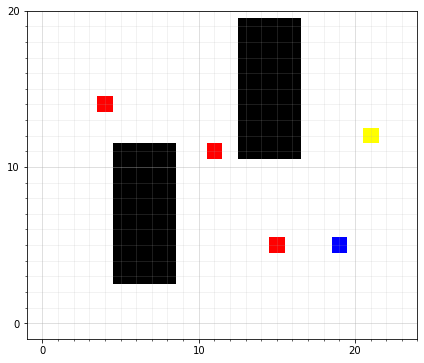

In [64]:
# ------- GRID -------
occupancy_grid, list_paintings_grid, start_grid, goal_grid, fig, ax = create_fill_grid()


**ASTAR**


In [82]:
def _get_movements_4n():
    """
    Get all possible 4-connectivity movements.
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0)]

def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
    return total_path

def A_Star(start, goal, h, coords, occupancy_grid):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal_m: goal node (x, y)
    :param occupancy_grid: the grid map
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """

    for point in [start, goal]: 
        assert point[0]>=0 and point[0]<max_val_x, "start or end goal not contained in the map (x)"
        assert point[1]>=0 and point[1]<max_val_y, "start or end goal not contained in the map (y)"
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]] == 1:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]] == 1:
        raise Exception('Goal node is not traversable')
    
    # get possible movements
    movements = _get_movements_4n()
    
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]

    # while there are still elements to investigate
    while openSet != []:
        
        #the node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == goal:
            return reconstruct_path(cameFrom, current), closedSet

        openSet.remove(current)
        closedSet.append(current)
        
        #for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0], neighbor[1]]==obstacle_here) or (neighbor in closedSet): 
                continue
                
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost
            
            if neighbor not in openSet:
                openSet.append(neighbor)
                
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                fScore[neighbor] = gScore[neighbor] + h[neighbor]

    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet


Visit paintings

In [85]:
def thymio_path(list_paintings_grid, start_grid, goal_grid, fig_astar, ax_astar):

    # Define the start and end goal constant with entrance and exit of museum
    entrance = tuple([int(start_grid[0]), int(start_grid[1])]) #(0,0)
    exit = tuple([int(goal_grid[0]), int(goal_grid[1])]) #(20,10)


    # List of all coordinates in the grid
    x,y = np.mgrid[0:max_val_x:1, 0:max_val_y:1]
    pos = np.empty(x.shape + (2,))
    pos[:, :, 0] = x; pos[:, :, 1] = y
    pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
    coords = list([(int(x[0]), int(x[1])) for x in pos])
    path = []
    visitedNodes = []

    p = input('Enter the order you want to to see the paintings in :')
    visiting_order = []
    i = 0
    x_t = []
    y_t = []
    pos_int = 0
    while i<len(p):
        if p[i].isdigit():
            visiting_order.append(int(p[i]))
            x_t.append(float(list_paintings_grid[int(p[i])][0]))
            y_t.append(float(list_paintings_grid[int(p[i])][1]))
        i = i + 1

    coords_goal = list([x_v, y_v] for (x_v,y_v) in zip(x_t,y_t))

    previous_pos = entrance #Start position
    goal_pos = coords_goal[0]

    for goal_pos in coords_goal:
        # Define the heuristic, here = distance to goal ignoring obstacles
        h = np.linalg.norm(pos - goal_pos, axis=-1)
        h = dict(zip(coords, h))
        goal_pos[0] = int(goal_pos[0])
        goal_pos[1] = int(goal_pos[1])

        # Run the A* algorithm #PUT ALL TOGETHER
        new_path, new_visitedNodes = A_Star(tuple(previous_pos), tuple(goal_pos), h, coords, occupancy_grid)
        if len(path) == 0:
            path = np.array(new_path).reshape(-1, 2).transpose()
        else:
            path = np.concatenate((path, np.array(new_path).reshape(-1, 2).transpose()), axis=1)

        if len(visitedNodes) == 0:
            visitedNodes = np.array(new_visitedNodes).reshape(-1, 2).transpose()
        else:
            visitedNodes = np.concatenate((visitedNodes, np.array(new_visitedNodes).reshape(-1, 2).transpose()), axis=1)

        previous_pos = goal_pos

    #####GO TO EXIT
    goal_pos = exit
    # Define the heuristic, here = distance to goal ignoring obstacles
    h = np.linalg.norm(pos - goal_pos, axis=-1)
    h = dict(zip(coords, h))

    # Run the A* algorithm
    new_path, new_visitedNodes = A_Star(tuple(previous_pos), goal_pos, h, coords, occupancy_grid) 
    if len(path) == 0:
            path = np.array(new_path).reshape(-1, 2).transpose()
    else:
        path = np.concatenate((path, np.array(new_path).reshape(-1, 2).transpose()), axis=1)

    if len(visitedNodes) == 0:
        visitedNodes = np.array(new_visitedNodes).reshape(-1, 2).transpose()
    else:
        visitedNodes = np.concatenate((visitedNodes, np.array(new_visitedNodes).reshape(-1, 2).transpose()), axis=1)

    ##### Displaying the map
    plt.figure()
    #fig_astar, ax_astar = create_empty_plot()
    cmap = colors.ListedColormap(['white', 'black', 'red', 'blue', 'yellow']) # Select the colors: Black = obstacles, Red = painting
    ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap)

    # Plot the best path found and the list of visited nodes
    ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange')
    ax_astar.plot(path[0], path[1], marker="o", color = 'blue')
    ax_astar.scatter(entrance[0], entrance[1], marker="o", color = 'green', s=200)
    ax_astar.scatter(exit[0], exit[1], marker="o", color = 'purple', s=200)

Enter the order you want to to see the paintings in :1 2 0


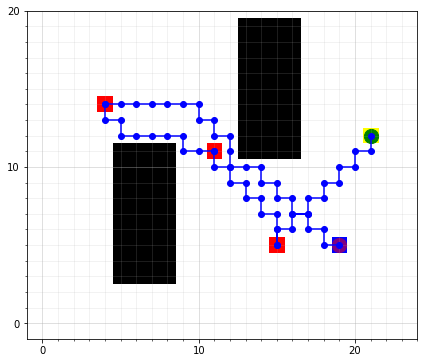

<Figure size 432x288 with 0 Axes>

In [86]:
occupancy_grid, list_paintings_grid, start_grid, goal_grid, fig, ax = create_fill_grid()

thymio_path(list_paintings_grid, start_grid, goal_grid, fig, ax)